In [5]:
import numpy as np
import pandas as pd
import string
import random
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
def preprocess_text(corpus):
    stop_words = set(stopwords.words('english'))
    sentences = corpus.split(".")
    training_data = []
    for sentence in sentences:
        words = sentence.strip().split()
        words = [w.strip(string.punctuation).lower() for w in words if w not in stop_words and w.strip()]
        if words:
            training_data.append(words)
    return training_data

# ------------------------------------------------------------
# Generate (center, context, label) DataFrame
# ------------------------------------------------------------
def generate_dataset(sentences, window_size=2, negative_ratio=2):
    vocab = sorted({word for sentence in sentences for word in sentence})
    word_to_index = {w: i for i, w in enumerate(vocab)}
    data = []

    for sentence in sentences:
        for i, center in enumerate(sentence):
            # positive context
            context_indices = list(range(max(0, i - window_size), min(len(sentence), i + window_size + 1)))
            for j in context_indices:
                if j != i:
                    data.append((center, sentence[j], 1))

            # negative samples
            negatives = random.sample(vocab, min(negative_ratio, len(vocab)))
            for neg in negatives:
                if neg not in sentence[max(0, i - window_size): min(len(sentence), i + window_size + 1)]:
                    data.append((center, neg, 0))
    
    df = pd.DataFrame(data, columns=['center', 'context', 'label'])
    df.drop_duplicates(inplace=True)
    return df, vocab, word_to_index

# ------------------------------------------------------------
# Initialize Weights
# ------------------------------------------------------------
def initialize_weights(V, N):
    W = np.random.uniform(-0.8, 0.8, (V, N))
    W1 = np.random.uniform(-0.8, 0.8, (V, N))
    return W, W1

# ------------------------------------------------------------
# Training using Negative Sampling Objective
# ------------------------------------------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def train_negative_sampling(df, vocab, word_to_index, embedding_dim=10, epochs=10, lr=0.01):
    V = len(vocab)
    W, W1 = initialize_weights(V, embedding_dim)

    for epoch in range(epochs):
        total_loss = 0
        for _, row in df.iterrows():
            c_idx = word_to_index[row['center']]
            o_idx = word_to_index[row['context']]
            label = row['label']

            v_c = W[c_idx]     # center word vector
            v_o = W1[o_idx]    # context word vector

            z = np.dot(v_c, v_o)
            p = sigmoid(z)
            loss = - (label * np.log(p + 1e-9) + (1 - label) * np.log(1 - p + 1e-9))
            total_loss += loss

            # Gradients
            grad = p - label
            W[c_idx] -= lr * grad * v_o
            W1[o_idx] -= lr * grad * v_c

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")

    return W, W1

# ------------------------------------------------------------
# Similarity Prediction
# ------------------------------------------------------------
def most_similar(word, W, vocab, word_to_index, top_n=5):
    if word not in word_to_index:
        print("Word not found in vocab.")
        return []
    idx = word_to_index[word]
    v = W[idx]
    sims = np.dot(W, v) / (np.linalg.norm(W, axis=1) * np.linalg.norm(v) + 1e-9)
    top_indices = np.argsort(-sims)[1:top_n+1]
    return [(vocab[i], float(sims[i])) for i in top_indices]

# ------------------------------------------------------------
# Example Usage
# ------------------------------------------------------------
corpus = """
The earth revolves around the sun. 
The moon revolves around the earth. 
The sun is the center of the solar system. 
Planets move in elliptical orbits. 
Gravity keeps the planets in orbit around the sun. 
Mars and Jupiter are planets. 
The moon has craters and mountains.
"""

sentences = preprocess_text(corpus)
df, vocab, word_to_index = generate_dataset(sentences, window_size=2, negative_ratio=3)
print("Training data sample:\n")
print(df.head())



Training data sample:

  center    context  label
0    the      earth      1
1    the   revolves      1
2    the     around      0
3    the  mountains      0
4    the       mars      0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amrr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
W, W1 = train_negative_sampling(df, vocab, word_to_index, embedding_dim=10, epochs=1000, lr=0.05)
print("\nMost similar words:")
for word in ["earth", "sun", "moon", "around"]:
    print(f"{word} → {most_similar(word, W, vocab, word_to_index, top_n=3)}")


Epoch 1/1000 | Loss: 118.8186
Epoch 2/1000 | Loss: 110.2531
Epoch 3/1000 | Loss: 103.1636
Epoch 4/1000 | Loss: 97.0251
Epoch 5/1000 | Loss: 91.5086
Epoch 6/1000 | Loss: 86.4066
Epoch 7/1000 | Loss: 81.5914
Epoch 8/1000 | Loss: 76.9890
Epoch 9/1000 | Loss: 72.5631
Epoch 10/1000 | Loss: 68.3024
Epoch 11/1000 | Loss: 64.2118
Epoch 12/1000 | Loss: 60.3041
Epoch 13/1000 | Loss: 56.5941
Epoch 14/1000 | Loss: 53.0945
Epoch 15/1000 | Loss: 49.8137
Epoch 16/1000 | Loss: 46.7550
Epoch 17/1000 | Loss: 43.9171
Epoch 18/1000 | Loss: 41.2953
Epoch 19/1000 | Loss: 38.8822
Epoch 20/1000 | Loss: 36.6690
Epoch 21/1000 | Loss: 34.6455
Epoch 22/1000 | Loss: 32.8011
Epoch 23/1000 | Loss: 31.1244
Epoch 24/1000 | Loss: 29.6035
Epoch 25/1000 | Loss: 28.2265
Epoch 26/1000 | Loss: 26.9813
Epoch 27/1000 | Loss: 25.8561
Epoch 28/1000 | Loss: 24.8394
Epoch 29/1000 | Loss: 23.9206
Epoch 30/1000 | Loss: 23.0896
Epoch 31/1000 | Loss: 22.3373
Epoch 32/1000 | Loss: 21.6554
Epoch 33/1000 | Loss: 21.0363
Epoch 34/1000 | 

In [8]:
for word in ["earth", "sun", "moon", "around"]:
    print(f"{word} → {most_similar(word, W, vocab, word_to_index, top_n=3)}")

earth → [('revolves', 0.8400694171949321), ('moon', 0.6464944617814162), ('sun', 0.3842535073572219)]
sun → [('moon', 0.6029600603840304), ('earth', 0.3842535073572219), ('the', 0.29876064168860933)]
moon → [('earth', 0.6464944617814162), ('sun', 0.6029600603840304), ('revolves', 0.391014730347456)]
around → [('orbit', 0.4746520990232288), ('keeps', 0.22597241276262525), ('the', 0.20852671102970954)]


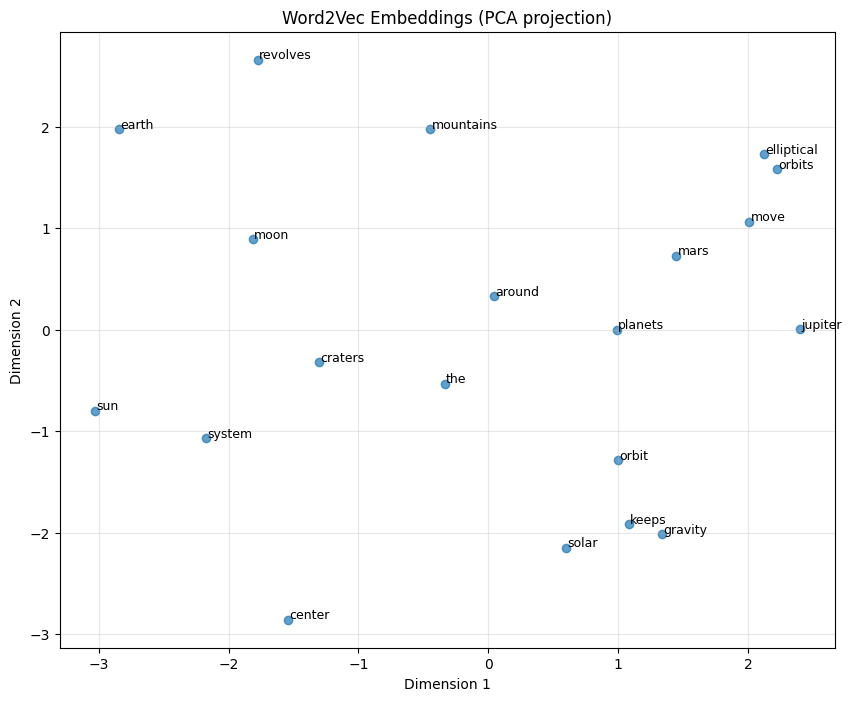

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# ------------------------------------------------------------
# Embedding Visualization
# ------------------------------------------------------------
def plot_embeddings(W, vocab, method='tsne'):
    """Plot 2D projection of learned word embeddings."""
    # Choose projection method
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)

    W_2d = reducer.fit_transform(W)

    plt.figure(figsize=(10, 8))
    plt.scatter(W_2d[:, 0], W_2d[:, 1], alpha=0.7)
    
    for i, word in enumerate(vocab):
        plt.text(W_2d[i, 0]+0.01, W_2d[i, 1]+0.01, word, fontsize=9)
    
    plt.title(f"Word2Vec Embeddings ({method.upper()} projection)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True, alpha=0.3)
    plt.show()


# Plot using t-SNE (good for small vocabularies)
plot_embeddings(W, vocab, method='pca')

# You can also try PCA (faster, more linear)
# plot_embeddings(W, vocab, method='pca')
